# 데이터 로드

파이토치는 ```torch.tuils.data.DataLoader``` 와 ```torch.utils.data.Dataset``` 두개의 데이터 프리미티브를 제공한다.

### 하이퍼 파라미터
* ```Iteration``` : 미니 배치를 이용해 학습하는 횟수
* ```Mini_Batch``` : 데이터 학습시 한번에 학습할 데이터의 양
* ```EPOCHS``` : 전체 데이터로 학습한 횟수
* ```BATCH_SIZE``` : MLP 모델을 학습할 때 필요한 데이터 개수

### Dataset : 데이터를 불러올 때 사용
* ```root``` : 데이터가 저장되는 경로
* ```train``` : 데이터가 테스트용인지 훈련 용인지를 결정합니다
* ```download``` : 인터넷에서 다운로드할 것인지 결정
* ```transform``` : 데이터 전처리 지정(transforms.ToTensor() 지정시 텐서 형태로 변경하고 정규화를 할 수 있다)

### DataLoader : 데이터를 미니 배치 단위로 분리해 지정
* ```dataset``` : 미니 배치 단위로 할당하고자 하는 데이터셋 지정 train_dataset/test_dataset
* ```batch_size``` : 미니배치 1개를 구성하는 데이터 개수
* ```shuffle``` : 데이터를 섞을 것인가

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

D:\download\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 파일에 대한 맞춤 데이터 셑 만들기
데이터 집합 클래스는 세기능을 구현해야 한다 `__init__`, `__len__`, `__getitem__`이다.
* `__init__` : 데이터 셋 개체를 인스턴스화 할때 한번만 실행된다. __이미지, 주석, 파일 및 디렉터리 초기화__ 등
* `__len__` : 데이터 세트의 __샘플 수__ 반환
* `__getitem__` : 주어진 인덱스에 있는 데이터 세트에서 샘플을 로드하고 반환. 인덱스를 기반으로 이미지 위치를 식별하고 사용하여 텐서로 변환하고 텐서 이미지와 해당 레이블 반환


In [2]:
import os
import pandas as pd
import torchvision.io as tvio

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_lables = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_lables)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = tvio.read_image(img_path)
        lable = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(lable)
        sample = {"image" : image, "label" : label}
        return sample

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


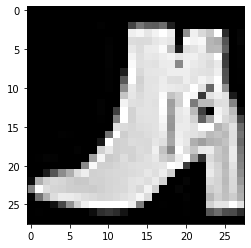

Lable : 9


In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Lable : {label}")

### 변형
데이터는 언제가 최종 처리가 아니기 때문에 **변환**을 해야한다.   
훈련을 위해 **정규화 된 텐서**로 원-핫 인코딩 된 레이블이 필요하며 이때 쓰이는 것이 `ToTensor`, `Lambda`이다
* `ToTensor` : 이미지나 넘파이 배열을 `Floattensor`로 변환하고 0~1 범위에서 픽셀 강고 값 조정
* `Lambda` : 사용자 정의 람다 함수로 직접 텐서로 바꿈

In [4]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)